In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

print(torchvision.__version__)

import os
import cv2
from torch.utils.data import Dataset
from natsort import natsorted
import pandas as pd
import numpy as np

import random

0.21.0+cu124


In [2]:
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, сделать выводы.

In [ ]:
!unzip dl-2025-competition-1.zip -d dl-2025-competition-1

In [6]:
base_dir = "/content/dl-2025-competition-1/data"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

print("Train exists:", os.path.exists(train_dir))
print("Test exists:", os.path.exists(test_dir))

train_images = []
train_labels = []

for class_id in range(100):
    class_dir = os.path.join(train_dir, str(class_id))
    images = sorted(glob(os.path.join(class_dir, "*.png")))
    train_images.extend(images)
    train_labels.extend([class_id] * len(images))

test_images = sorted(glob(os.path.join(test_dir, "*.png")))

print("\nTotal train images:", len(train_images))
print("Total test images:", len(test_images))
print("\nExample train paths:", train_images[:3])
print("Example test paths:", test_images[:3])

class_counts = pd.Series(train_labels).value_counts().sort_index()
print("\nClass distribution:")
print(class_counts.head(10))

Train exists: True
Test exists: True

Total train images: 9510
Total test images: 3878

Example train paths: ['/content/dl-2025-competition-1/data/train/0/5926.png', '/content/dl-2025-competition-1/data/train/0/5927.png', '/content/dl-2025-competition-1/data/train/0/5928.png']
Example test paths: ['/content/dl-2025-competition-1/data/test/0.png', '/content/dl-2025-competition-1/data/test/1.png', '/content/dl-2025-competition-1/data/test/10.png']

Class distribution:
0    110
1    109
2    143
3    119
4    136
5     45
6    123
7    137
8     45
9     49
Name: count, dtype: int64


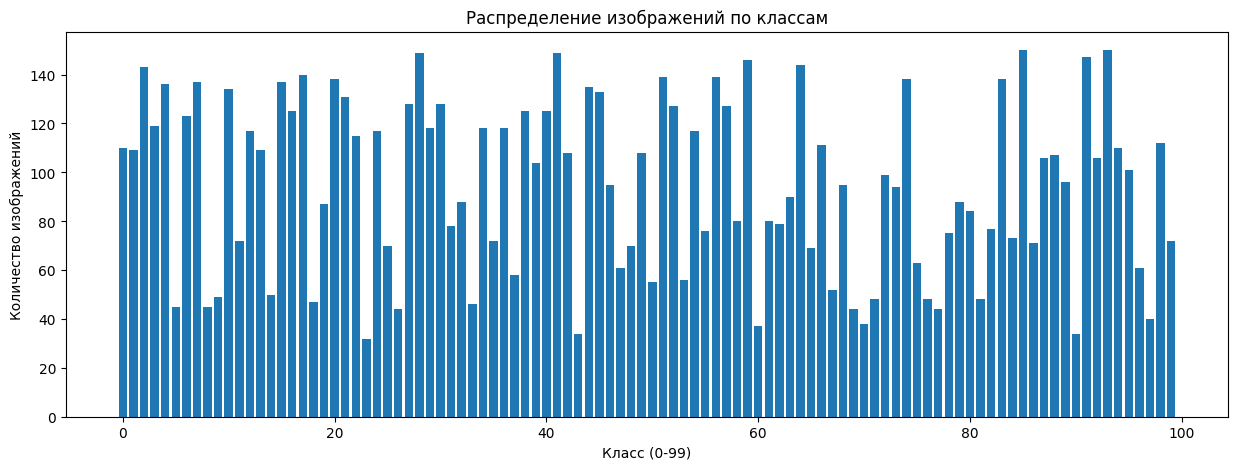

Минимальное количество изображений в классе: 32
Максимальное количество изображений в классе: 150
Среднее количество изображений: 95.1


In [7]:
class_counts = pd.Series(train_labels).value_counts().sort_index()

plt.figure(figsize=(15, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Класс (0-99)")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.show()

print("Минимальное количество изображений в классе:", class_counts.min())
print("Максимальное количество изображений в классе:", class_counts.max())
print("Среднее количество изображений:", class_counts.mean())

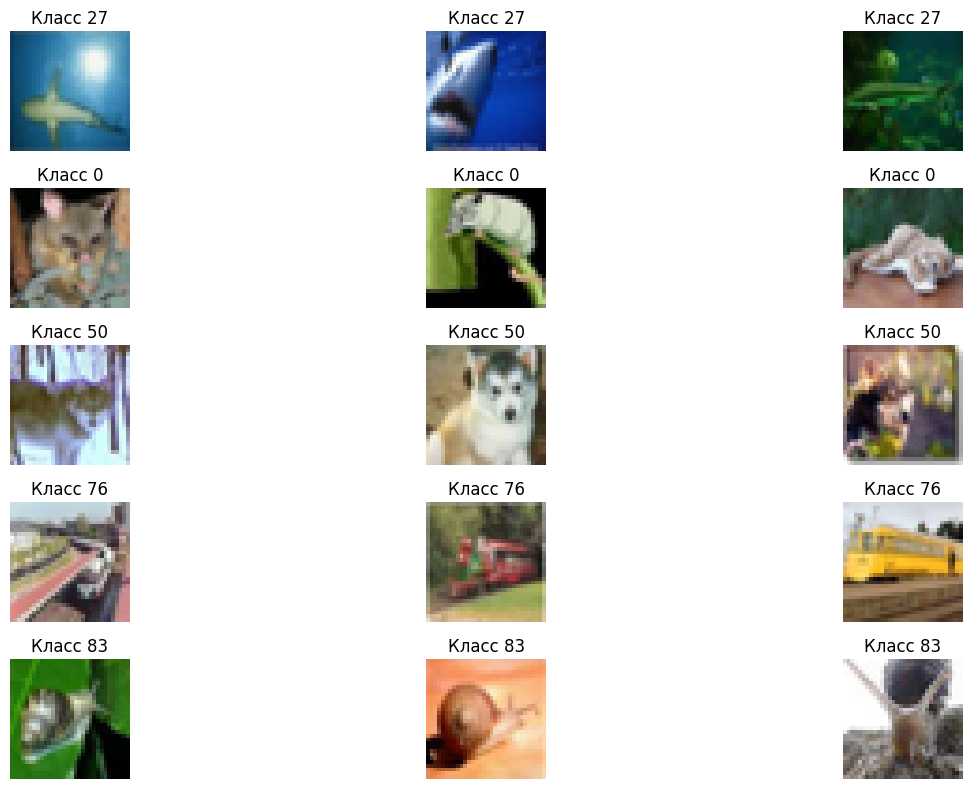

In [8]:
random_classes = random.sample(range(100), 5)

plt.figure(figsize=(15, 8))

for i, class_id in enumerate(random_classes):
    class_images = [img for img, lbl in zip(train_images, train_labels) if lbl == class_id]
    sample_images = random.sample(class_images, 3)

    for j, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        plt.subplot(5, 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(f"Класс {class_id}")
        plt.axis('off')

plt.tight_layout()
plt.show()

Классы несбалансированы (от 32 до 150 изображений), что может ухудшить распознавание редких классов. Качество изображений крайне низкое (пиксельные, плохо различимые), что усложняет обучение модели

In [9]:
train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    train_images,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=42
)

2) Проанализировать хороший аугментационный пайплайн с помощью albumentations. Собрать подготовленный пайплайн в погрузчик данных на модель.

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.LongestMaxSize(max_size=256),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0),

    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),

    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),
    A.MotionBlur(p=0.1),

    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=10,
        border_mode=0,
        p=0.3
    ),

    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
val_transform = A.Compose([
    A.LongestMaxSize(max_size=256),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0),
    A.CenterCrop(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [11]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):

        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]


        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return image, label

In [12]:
train_dataset = CustomDataset(train_imgs, train_lbls, transform=train_transform)
val_dataset = CustomDataset(val_imgs, val_lbls, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [13]:
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 3, 224, 224])
tensor([52, 49, 59, 24, 28, 41, 72, 82, 94, 33, 51, 65, 16, 91, 44, 59, 93, 91,
        12, 13, 16, 21, 20, 63, 23, 87, 51,  4, 92, 64,  6, 72])


3) Поделить данные на трейн-валидацию, обучить базовую модель (с и без transfer learning) без навороченных аугментаций (только отражение во горизонтали и вертикали) и с навороченными. Попробуйте применить продвинутые методы апскейлинга для подачи модели нужного размера для transfer learning. Проверить результаты моделей с аугментацией на тесте и без. Сделать аугментацию моделей на валидации (или тесте на каггле). Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом.

In [28]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256*28*28, 1024)
        self.fc2 = nn.Linear(1024, 100)  # 100 классов

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [29]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

patience = 5
best_loss = float('inf')
patience_counter = 0

Epoch 1/20, Train Loss: 4.5315, Train Accuracy: 3.00%
Validation Loss: 4.2715, Validation Accuracy: 5.31%
Epoch 2/20, Train Loss: 4.1500, Train Accuracy: 6.24%
Validation Loss: 3.9592, Validation Accuracy: 9.52%
Epoch 3/20, Train Loss: 3.9373, Train Accuracy: 9.40%
Validation Loss: 3.8678, Validation Accuracy: 10.73%
Epoch 4/20, Train Loss: 3.7885, Train Accuracy: 12.05%
Validation Loss: 3.7708, Validation Accuracy: 12.62%
Epoch 5/20, Train Loss: 3.6799, Train Accuracy: 14.14%
Validation Loss: 3.6524, Validation Accuracy: 14.88%
Epoch 6/20, Train Loss: 3.5455, Train Accuracy: 15.72%
Validation Loss: 3.6092, Validation Accuracy: 14.93%
Epoch 7/20, Train Loss: 3.4269, Train Accuracy: 17.74%
Validation Loss: 3.4680, Validation Accuracy: 18.56%
Epoch 8/20, Train Loss: 3.1592, Train Accuracy: 22.83%
Validation Loss: 3.3858, Validation Accuracy: 21.66%
Epoch 9/20, Train Loss: 3.0591, Train Accuracy: 25.21%
Validation Loss: 3.3553, Validation Accuracy: 21.82%
Epoch 10/20, Train Loss: 3.0184, 

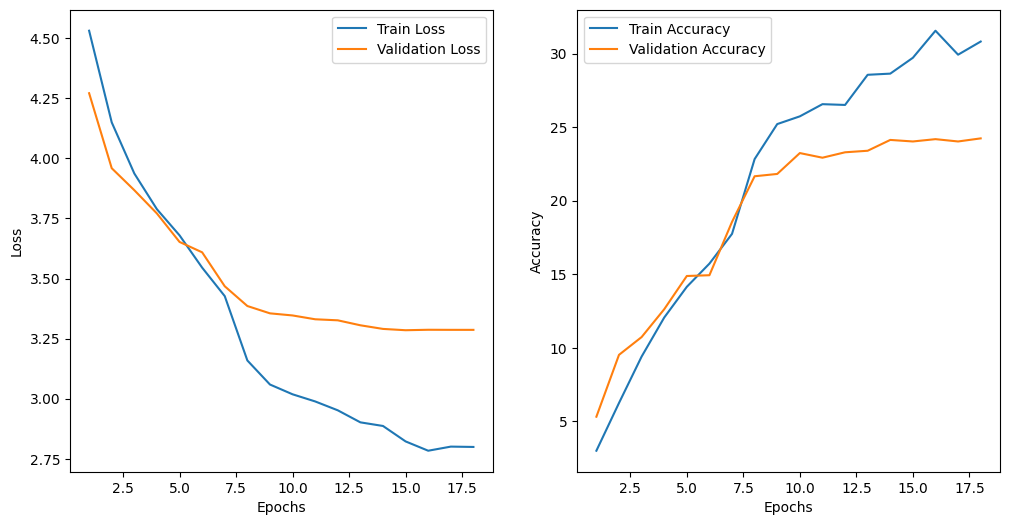

In [30]:
import torch
import matplotlib.pyplot as plt

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_loss = float('inf')
patience = 3
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total * 100

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

epochs_to_plot = min(num_epochs, len(train_losses))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_to_plot + 1), train_losses[:epochs_to_plot], label='Train Loss')
plt.plot(range(1, epochs_to_plot + 1), val_losses[:epochs_to_plot], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_to_plot + 1), train_accuracies[:epochs_to_plot], label='Train Accuracy')
plt.plot(range(1, epochs_to_plot + 1), val_accuracies[:epochs_to_plot], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [31]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms
from glob import glob
import pandas as pd
import torch

# Кастомный датасет
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, img_path

# Трансформации для тестовых данных
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Пути к тестовым изображениям
test_dir = "/content/dl-2025-competition-1/data/test"
test_images = sorted(glob(os.path.join(test_dir, "*.png")))

# Создаем DataLoader для тестов
test_dataset = CustomImageDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Загружаем модель
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Списки для хранения предсказанных меток и идентификаторов
test_preds = []
test_ids = []

# Выполняем предсказания
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)

        # Получаем предсказания от модели
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Добавляем предсказания и идентификаторы
        test_preds.extend(predicted.cpu().numpy())
        test_ids.extend([os.path.splitext(os.path.basename(path))[0] for path in paths])  # Извлекаем id (имя файла без расширения)

# Создаем DataFrame с id и target
submission = pd.DataFrame({
    'id': test_ids,
    'target': test_preds
})

# Сохраняем результат в CSV
submission.to_csv("submission.csv", index=False)

print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'


In [ ]:
from torchvision import models, transforms
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Получаем количество входных признаков для последнего слоя
num_ftrs = model.classifier[1].in_features

# Заменяем последний слой на классификацию 100 классов
model.classifier[1] = nn.Linear(num_ftrs, 100)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 93.5MB/s]


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

patience = 5
best_loss = float('inf')
patience_counter = 0

Epoch 1/20, Train Loss: 3.5192, Train Accuracy: 16.57%
Validation Loss: 2.9981, Validation Accuracy: 27.18%
Epoch 2/20, Train Loss: 2.6852, Train Accuracy: 30.28%
Validation Loss: 2.4391, Validation Accuracy: 35.86%
Epoch 3/20, Train Loss: 2.3722, Train Accuracy: 36.49%
Validation Loss: 2.2810, Validation Accuracy: 39.33%
Epoch 4/20, Train Loss: 2.1496, Train Accuracy: 41.48%
Validation Loss: 2.2050, Validation Accuracy: 41.96%
Epoch 5/20, Train Loss: 1.9960, Train Accuracy: 44.65%
Validation Loss: 1.9684, Validation Accuracy: 46.16%
Epoch 6/20, Train Loss: 1.8806, Train Accuracy: 47.75%
Validation Loss: 1.9396, Validation Accuracy: 48.48%
Epoch 7/20, Train Loss: 1.7668, Train Accuracy: 50.35%
Validation Loss: 1.9156, Validation Accuracy: 48.84%
Epoch 8/20, Train Loss: 1.3009, Train Accuracy: 62.30%
Validation Loss: 1.4592, Validation Accuracy: 58.68%
Epoch 9/20, Train Loss: 1.0877, Train Accuracy: 67.93%
Validation Loss: 1.4357, Validation Accuracy: 60.46%
Epoch 10/20, Train Loss: 1.0

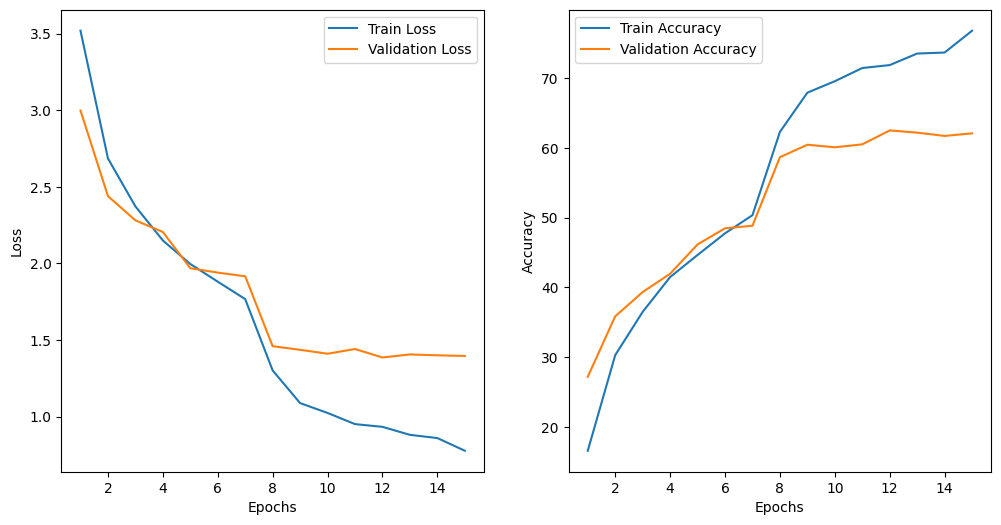

In [ ]:
import torch
import matplotlib.pyplot as plt

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_loss = float('inf')
patience = 3
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total * 100

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

epochs_to_plot = min(num_epochs, len(train_losses))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_to_plot + 1), train_losses[:epochs_to_plot], label='Train Loss')
plt.plot(range(1, epochs_to_plot + 1), val_losses[:epochs_to_plot], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_to_plot + 1), train_accuracies[:epochs_to_plot], label='Train Accuracy')
plt.plot(range(1, epochs_to_plot + 1), val_accuracies[:epochs_to_plot], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms
from glob import glob
import pandas as pd
import torch

# Кастомный датасет
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, img_path

# Трансформации для тестовых данных
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Пути к тестовым изображениям
test_dir = "/content/dl-2025-competition-1/data/test"
test_images = sorted(glob(os.path.join(test_dir, "*.png")))

# Создаем DataLoader для тестов
test_dataset = CustomImageDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Загружаем модель
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Списки для хранения предсказанных меток и идентификаторов
test_preds = []
test_ids = []

# Выполняем предсказания
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)

        # Получаем предсказания от модели
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Добавляем предсказания и идентификаторы
        test_preds.extend(predicted.cpu().numpy())
        test_ids.extend([os.path.splitext(os.path.basename(path))[0] for path in paths])  # Извлекаем id (имя файла без расширения)

# Создаем DataFrame с id и target
submission = pd.DataFrame({
    'id': test_ids,
    'target': test_preds
})

# Сохраняем результат в CSV
submission.to_csv("submission_2.csv", index=False)

print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'


In [ ]:
model = models.resnet18(pretrained=True)

# Заменяем последний слой на 100 классов
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

patience = 5
best_loss = float('inf')
patience_counter = 0

Epoch 1/20, Train Loss: 3.8771, Train Accuracy: 11.72%
Validation Loss: 3.4248, Validation Accuracy: 18.24%
Epoch 2/20, Train Loss: 2.9790, Train Accuracy: 25.71%
Validation Loss: 2.7156, Validation Accuracy: 32.97%
Epoch 3/20, Train Loss: 2.5837, Train Accuracy: 32.47%
Validation Loss: 2.5506, Validation Accuracy: 35.96%
Epoch 4/20, Train Loss: 2.2788, Train Accuracy: 40.26%
Validation Loss: 2.2507, Validation Accuracy: 40.96%
Epoch 5/20, Train Loss: 2.0885, Train Accuracy: 43.90%
Validation Loss: 2.0751, Validation Accuracy: 43.69%
Epoch 6/20, Train Loss: 1.9266, Train Accuracy: 47.54%
Validation Loss: 2.1294, Validation Accuracy: 43.48%
Epoch 7/20, Train Loss: 1.7490, Train Accuracy: 51.46%
Validation Loss: 2.0269, Validation Accuracy: 47.69%
Epoch 8/20, Train Loss: 1.2704, Train Accuracy: 64.60%
Validation Loss: 1.5310, Validation Accuracy: 56.94%
Epoch 9/20, Train Loss: 1.0958, Train Accuracy: 69.98%
Validation Loss: 1.5003, Validation Accuracy: 58.20%
Epoch 10/20, Train Loss: 1.0

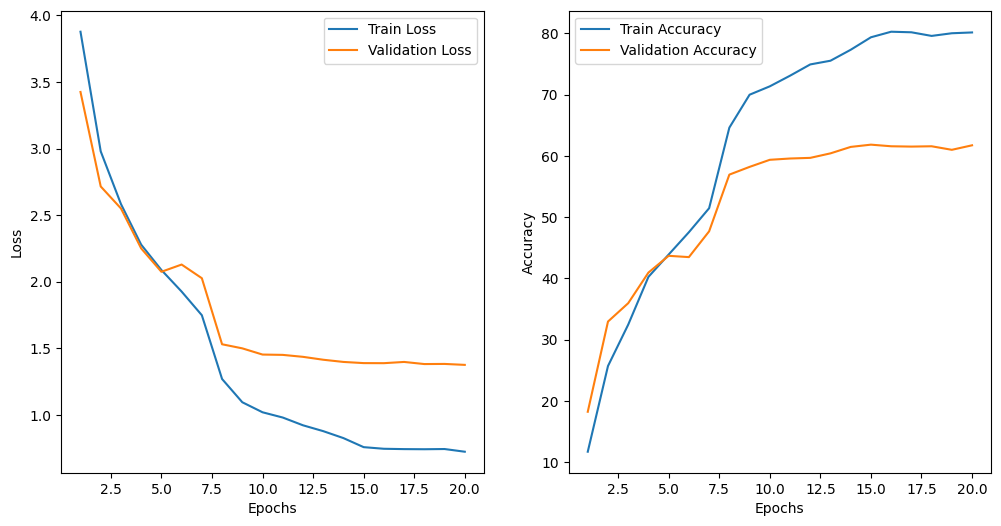

In [ ]:
import torch
import matplotlib.pyplot as plt

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_loss = float('inf')
patience = 3
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total * 100

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

epochs_to_plot = min(num_epochs, len(train_losses))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_to_plot + 1), train_losses[:epochs_to_plot], label='Train Loss')
plt.plot(range(1, epochs_to_plot + 1), val_losses[:epochs_to_plot], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_to_plot + 1), train_accuracies[:epochs_to_plot], label='Train Accuracy')
plt.plot(range(1, epochs_to_plot + 1), val_accuracies[:epochs_to_plot], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, img_path

# Трансформации для тестовых данных
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Пути к тестовым изображениям
test_dir = "/content/dl-2025-competition-1/data/test"
test_images = sorted(glob(os.path.join(test_dir, "*.png")))

# Создаем DataLoader для тестов
test_dataset = CustomImageDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Загружаем модель
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Списки для хранения предсказанных меток и идентификаторов
test_preds = []
test_ids = []

# Выполняем предсказания
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)

        # Получаем предсказания от модели
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Добавляем предсказания и идентификаторы
        test_preds.extend(predicted.cpu().numpy())
        test_ids.extend([os.path.splitext(os.path.basename(path))[0] for path in paths])  # Извлекаем id (имя файла без расширения)

# Создаем DataFrame с id и target
submission = pd.DataFrame({
    'id': test_ids,
    'target': test_preds
})

# Сохраняем результат в CSV
submission.to_csv("submission_3.csv", index=False)

print("Predictions saved to 'submission_3.csv'")

Predictions saved to 'submission_3.csv'


Всё, что ниже, для выбивания скора на каггле

In [33]:
from torchvision import models, transforms
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 100)  # 100 классов
model = model.to(device)

In [34]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

criterion = nn.CrossEntropyLoss()

patience = 5
best_loss = float('inf')
patience_counter = 0

Epoch 1/20, Train Loss: 3.6712, Train Accuracy: 15.72%
Validation Loss: 3.2001, Validation Accuracy: 23.34%
Epoch 2/20, Train Loss: 2.7172, Train Accuracy: 30.13%
Validation Loss: 2.4785, Validation Accuracy: 34.96%
Epoch 3/20, Train Loss: 2.2682, Train Accuracy: 40.19%
Validation Loss: 2.3948, Validation Accuracy: 37.59%
Epoch 4/20, Train Loss: 1.9885, Train Accuracy: 46.14%
Validation Loss: 2.0366, Validation Accuracy: 46.11%
Epoch 5/20, Train Loss: 1.8120, Train Accuracy: 49.65%
Validation Loss: 1.8415, Validation Accuracy: 50.68%
Epoch 6/20, Train Loss: 1.6597, Train Accuracy: 53.96%
Validation Loss: 1.8054, Validation Accuracy: 52.42%
Epoch 7/20, Train Loss: 1.4692, Train Accuracy: 58.18%
Validation Loss: 1.7649, Validation Accuracy: 53.63%
Epoch 8/20, Train Loss: 1.0266, Train Accuracy: 71.21%
Validation Loss: 1.3370, Validation Accuracy: 63.25%
Epoch 9/20, Train Loss: 0.8564, Train Accuracy: 76.21%
Validation Loss: 1.2823, Validation Accuracy: 64.67%
Epoch 10/20, Train Loss: 0.7

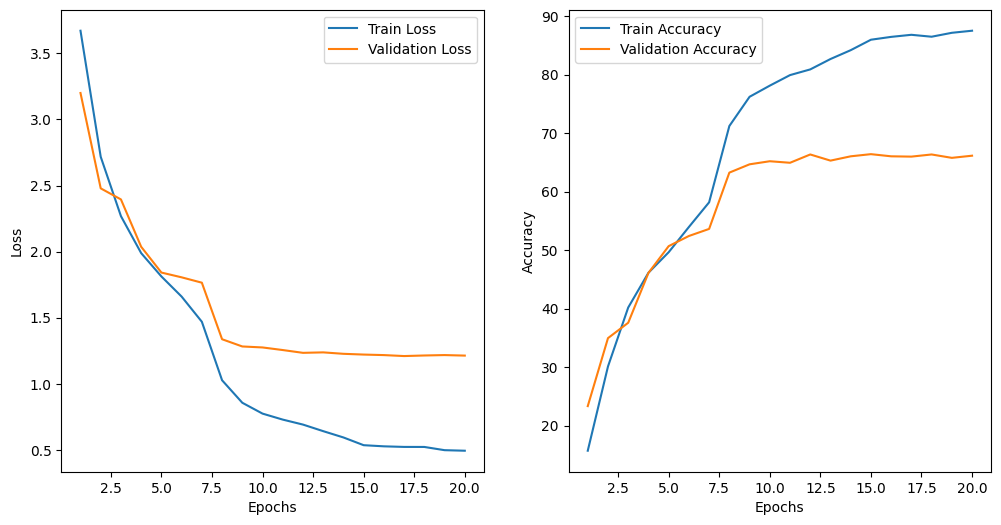

In [35]:
import torch
import matplotlib.pyplot as plt

num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_loss = float('inf')
patience = 3
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total * 100

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break

epochs_to_plot = min(num_epochs, len(train_losses))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_to_plot + 1), train_losses[:epochs_to_plot], label='Train Loss')
plt.plot(range(1, epochs_to_plot + 1), val_losses[:epochs_to_plot], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_to_plot + 1), train_accuracies[:epochs_to_plot], label='Train Accuracy')
plt.plot(range(1, epochs_to_plot + 1), val_accuracies[:epochs_to_plot], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [36]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, img_path

# Трансформации для тестовых данных
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Пути к тестовым изображениям
test_dir = "/content/dl-2025-competition-1/data/test"
test_images = sorted(glob(os.path.join(test_dir, "*.png")))

# Создаем DataLoader для тестов
test_dataset = CustomImageDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Загружаем модель
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Списки для хранения предсказанных меток и идентификаторов
test_preds = []
test_ids = []

# Выполняем предсказания
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)

        # Получаем предсказания от модели
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Добавляем предсказания и идентификаторы
        test_preds.extend(predicted.cpu().numpy())
        test_ids.extend([os.path.splitext(os.path.basename(path))[0] for path in paths])  # Извлекаем id (имя файла без расширения)

# Создаем DataFrame с id и target
submission = pd.DataFrame({
    'id': test_ids,
    'target': test_preds
})

# Сохраняем результат в CSV
submission.to_csv("submission_4.csv", index=False)

print("Predictions saved to 'submission_4.csv'")

Predictions saved to 'submission_4.csv'


4) Обучить простенький генератор для дополнительной аугментации данных, настроить для него условную генерацию на классах и аугментационный пайплайн. Изучить влияние сгенерированных данных на перформанс модели.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=64, num_classes=100):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, 50)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, 4, 2, 1),         # (B, 32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),        # (B, 64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),       # (B, 128, 28, 28)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()
        )

        enc_output_dim = 128 * 28 * 28
        self.fc_mu = nn.Linear(enc_output_dim, latent_dim)
        self.fc_logvar = nn.Linear(enc_output_dim, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + 50, 128 * 28 * 28)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 28, 28)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # (B, 64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # (B, 32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # (B, 3, 224, 224)
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        # Добавляем условие (label) как канал
        label_map = labels.view(-1, 1, 1, 1).float().expand(-1, 1, x.size(2), x.size(3))
        x = torch.cat([x, label_map], dim=1)  # (B, 4, H, W)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        logvar = torch.clamp(logvar, min=-10, max=10)  # Защита от NaN
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        label_embed = self.label_emb(labels)
        x = torch.cat([z, label_embed], dim=1)
        x = self.decoder_input(x)
        return self.decoder(x)

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, labels)
        return recon, mu, logvar

In [17]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.transforms import ToTensor

vae = ConditionalVAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)  # снизили LR
criterion = nn.MSELoss()

vae_dataset = CustomDataset(train_imgs, train_lbls, transform=val_transform)
vae_loader = DataLoader(vae_dataset, batch_size=64, shuffle=True)

for epoch in range(5):
    vae.train()
    total_loss = 0
    for images, labels in vae_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        recon, mu, logvar = vae(images, labels)

        recon_loss = criterion(recon, images)

        logvar = torch.clamp(logvar, min=-10, max=10)

        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + 0.001 * kl_loss

        if torch.isnan(loss) or torch.isinf(loss):
            print("NaN or Inf detected. Skipping this batch.")
            continue

        loss.backward()

        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 148.4056
Epoch 2: Loss = 115.6047
Epoch 3: Loss = 103.2354
Epoch 4: Loss = 97.4284
Epoch 5: Loss = 94.3147


In [18]:
def generate_images(vae, class_id, n=100):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(n, vae.latent_dim).to(device)
        labels = torch.full((n,), class_id, dtype=torch.long).to(device)
        gen_images = vae.decode(z, labels)
        return gen_images.cpu()

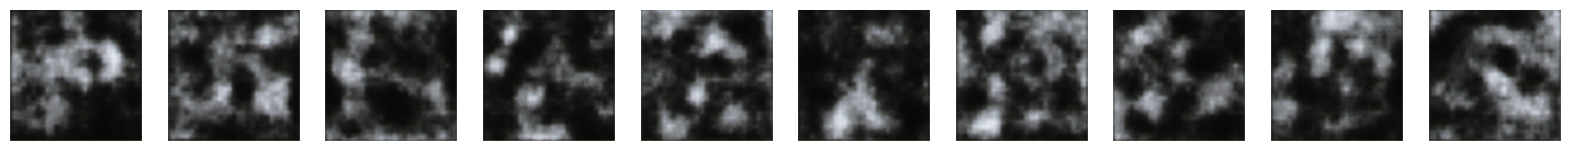

In [19]:
import matplotlib.pyplot as plt

def show_images(images, n=10):
    images = images[:n]  # Покажем первые n
    fig, axes = plt.subplots(1, n, figsize=(n * 2, 2))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Пример:
gen_images = generate_images(vae, class_id=5, n=10)
show_images(gen_images)

In [20]:
import albumentations as A
from torch.utils.data import Dataset
import numpy as np
import torch
import torchvision.transforms as T

class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, aug_images, aug_labels, transform=None):
        self.original_dataset = original_dataset
        self.aug_images = aug_images
        self.aug_labels = aug_labels
        self.transform = transform

        assert len(aug_images) == len(aug_labels), "Количество изображений и меток должно совпадать"

    def __len__(self):
        return len(self.original_dataset) + len(self.aug_images)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            img, label = self.original_dataset[idx]
        else:
            img = self.aug_images[idx - len(self.original_dataset)]
            label = self.aug_labels[idx - len(self.original_dataset)]

            if self.transform:
                  img = img.permute(1, 2, 0).cpu().numpy()  # (H, W, C) numpy
                  transformed = self.transform(image=img)
                  img = transformed['image']  # Уже тензор!
        return img, torch.tensor(label, dtype=torch.long)

In [21]:
# Определяем аугментации с помощью albumentations
train_transform = A.Compose([
    A.RandomCrop(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
    A.pytorch.transforms.ToTensorV2()
])

In [22]:
# Генерируем изображения для всех классов
aug_images = []
aug_labels = []

for class_id in range(100):  # или только для малочастотных классов
    gen_imgs = generate_images(vae, class_id, n=50)  # 50 изображений на класс
    aug_images.append(gen_imgs)
    aug_labels.extend([class_id] * 50)

aug_images = torch.cat(aug_images, dim=0)
aug_labels = torch.tensor(aug_labels, dtype=torch.long)

In [23]:
# Создаем датасет с аугментированными данными
augmented_dataset = AugmentedDataset(
    original_dataset=train_dataset,  # ваш оригинальный датасет
    aug_images=aug_images,
    aug_labels=aug_labels,
    transform=train_transform
)

# Загрузчик данных
augmented_loader = DataLoader(
    augmented_dataset,
    batch_size=64,
    shuffle=True
)

In [24]:
def train_model_with_augmented_data(model, augmented_loader, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch_idx, (images, labels) in enumerate(augmented_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(augmented_loader)
        epoch_accuracy = correct_predictions / total_predictions * 100

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return train_losses, train_accuracies

# Обучаем модель
train_losses, train_accuracies = train_model_with_augmented_data(model, augmented_loader)

<ipython-input-20-a712db8360a0>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img, torch.tensor(label, dtype=torch.long)


Epoch 1/5, Loss: 4.0441, Accuracy: 12.93%
Epoch 2/5, Loss: 3.1589, Accuracy: 29.32%
Epoch 3/5, Loss: 2.8165, Accuracy: 35.90%
Epoch 4/5, Loss: 2.6221, Accuracy: 40.46%
Epoch 5/5, Loss: 2.4931, Accuracy: 43.40%


In [27]:
# Трансформации для теста
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Загрузка путей к тестовым изображениям
test_dir = "/content/dl-2025-competition-1/data/test"
test_images = sorted(glob(os.path.join(test_dir, "*.png")))

# Кастомный датасет для теста
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path).split('.')[0]  # возвращаем id без расширения

# Создание DataLoader для теста
test_dataset = CustomImageDataset(test_images, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Переводим модель в режим оценки
model.eval()

# Предсказания
test_preds = []
test_ids = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_ids.extend(ids)

# Создание и сохранение submission
submission = pd.DataFrame({'id': test_ids, 'target': test_preds})
submission.to_csv("submission_augmented.csv", index=False)

print("Predictions saved to 'submission_augmented.csv'")


Predictions saved to 'submission_augmented.csv'
